# Simulate Sequences

In [13]:
### IMPORTS
from simulate import run_simulation

### Run Single Simulation

In [ ]:
# Number of unique monomers
N_MONs = 4

# Molar ratios of each monomer
# ex. if N_MONs = 4: [0.5, 0.25, 0.20, 0.05]
MRs = [50, 25, 20, 5]

# What model of copolymerization to use? (1) mayolewis (terminal) or (2) penultimate
# NOTE FOR NOW ONLY MAYO-LEWIS IMPLEMENTED.
#model = "mayolewis"

# reactivity ratios of monomers, ex. for 4 monomers:
#[r12, r13, r14]
#[r21, r23, r24]
#[r31, r32, r34]
#[r41, r42, r43]
RRs = ([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])

# % conversion targetted (0-1), i.e. how much of the monomer pool do you want to use
conv = 0.5

# average degree of polymerization (chain length) you are targetting at YOUR conversion, NOT at 100%.
avgDP = 100

# number of polymer chains to simulate
N_CHAINs = 10000

# Chain transfer % (0-1)
# TODO: replace this with direct PDI control (not sure how)
# NOTE TO SELF: for now just fix CTP such that PDI ~ 1.2, as thats roughly the control our RAFT synthesis gives.
CTP = 0.05

# cutoff DP of chains considered as polymers not oligomers that get "purified" out
# set to 0 if you don't want to do any filtration
PRUNE_OLIGOMERS = 10

In [ ]:
run_simulation(N_MONs, N_CHAINs, MRs, RRs, avgDP, conv, CTP, PRUNE_OLIGOMERS)

### Run Multiple Simulations

Currently, various DPs are simulated - this can/should be changed to vary other things too, as well as instead of just simulating 4, a linspace between a max and min specifying the number of sample points.

In [14]:
# Number of unique monomers
N_MONs = 4

# Molar ratios of each monomer
# ex. if N_MONs = 4: [0.5, 0.25, 0.20, 0.05]
MRs = [50, 25, 20, 5]

# reactivity ratios of monomers, ex. for 4 monomers:
#[r12, r13, r14]
#[r21, r23, r24]
#[r31, r32, r34]
#[r41, r42, r43]
RRs = ([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])

# % conversion targetted (0-1), i.e. how much of the monomer pool do you want to use
conv = 0.5

# average degree of polymerization (chain length) you are targetting at YOUR conversion, NOT at 100%.
avgDPs = [50, 75, 100, 125, 150, 175, 200, 225, 250]

# number of polymer chains to simulate
N_CHAINs = 10000

# Chain transfer % (0-1)
# TODO: replace this with direct PDI control (not sure how)
# NOTE TO SELF: for now just fix CTP such that PDI ~ 1.2, as thats roughly the control our RAFT synthesis gives.
CTP = 0.1

# cutoff DP of chains considered as polymers not oligomers that get "purified" out
# set to 0 if you don't want to do any filtration
PRUNE_OLIGOMERS = 10

In [15]:
for avgDP in avgDPs:
    run_simulation(N_MONs, N_CHAINs, MRs, RRs, avgDP, conv, CTP, PRUNE_OLIGOMERS)

Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP50_conv50_CTP10_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP75_conv50_CTP10_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP100_conv50_CTP10_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP125_conv50_CTP10_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP150_conv50_CTP10_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP175_conv50_CTP10_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP200_conv50_CTP10_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP225_conv50_CTP10_FILT10.csv
Simulation done! Sequence file saved @ outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP250_conv50_CTP10_FILT10.csv


# Seq Analysis

In [16]:
import pandas as pd
import numpy as np
import glob, os
import csv
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import copy
import csv
from tqdm import tqdm_notebook
from itertools import tee

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 35

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Load sequence CSV files and set monomer properties
Specify path and what monomers each label corresponds to here (by specifying Mw and HLB)

In [17]:
### IMPORT ALL SEQUENCE CSV FILES IN FOLDER SPECIFIED BY PATH

path = "outputs"
csv_files = []
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_files.append(os.path.join(path, file))
csv_files = sorted(csv_files)
print("Number of sequence files:", len(csv_files))
print(csv_files)

### SET MOLECULAR WEIGHTS OF MONOMERS IN ORDER OF LABEL (labels are 1 indexed)
Mw = [100.121,500,198.3,246.32]
HLBs = [8.45, 11.42, 5.125, 18.5]

Number of sequence files: 9
['outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP100_conv50_CTP10_FILT10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP125_conv50_CTP10_FILT10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP150_conv50_CTP10_FILT10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP175_conv50_CTP10_FILT10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP200_conv50_CTP10_FILT10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP225_conv50_CTP10_FILT10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP250_conv50_CTP10_FILT10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP50_conv50_CTP10_FILT10.csv', 'outputs/NM4_MR[50, 25, 20, 5]_NC10000_DP75_conv50_CTP10_FILT10.csv']


### Calculate general sequence statistics and average properties for all sequences by batch
Output is a dataframe with column headers: [Batch Name	NumSeqs	Avg Mn	Avg Mw	PDI	Avg DP]

In [18]:
### CALCULATE AVERAGE DP, Mn, Mw & PDI OF ALL SEQUENCES

names = []
num_seqs = []
avg_Mns = []
avg_Mws = []
PDIs = []
avg_DPs = []
seqs = []

for m in tqdm_notebook(range(len(csv_files))):
    seq = []

    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)
    raw_seq = copy.deepcopy(seq)
    seqs.append(raw_seq)
    seqlen = np.zeros(i)
    seqweight = np.zeros(i)
    seqweight2 = np.zeros(i)

    for j in range(0,i):
        seqlen[j] = len(seq[j])
        for k in range(len(seq[j])):
            seq[j][k] = Mw[int(seq[j][k])-1]
        seqweight[j] = sum(seq[j])
        seqweight2[j] = (sum(seq[j])**2)

    AvgMw = sum(seqweight2)/sum(seqweight)
    AvgMn = sum(seqweight)/len(seqweight)
    PDI = AvgMw/AvgMn
    DP = sum(seqlen)/len(seqlen)

    names.append(csv_files[m].replace(path, '').replace('/', '').replace('.csv', ''))
    num_seqs.append(i)
    avg_Mns.append(AvgMn)
    avg_Mws.append(AvgMw)
    PDIs.append(PDI)
    avg_DPs.append(DP)
    
d = {'Batch Name': names, 'NumSeqs': num_seqs, 'Avg Mn': avg_Mns, 'Avg Mw': avg_Mws, 'PDI': PDIs, 'Avg DP': avg_DPs}
df = pd.DataFrame(data=d)
df

,Batch Name,NumSeqs,Avg Mn,Avg Mw,PDI,Avg DP
0,"NM4_MR[50, 25, 20, 5]_NC10000_DP100_conv50_CTP...",9977,22745.814522,27071.581059,1.190179,100.213591
1,"NM4_MR[50, 25, 20, 5]_NC10000_DP125_conv50_CTP...",9997,28395.398340,32795.040815,1.154942,125.035411
2,"NM4_MR[50, 25, 20, 5]_NC10000_DP150_conv50_CTP...",9999,34044.652617,38303.902488,1.125108,150.014101
3,"NM4_MR[50, 25, 20, 5]_NC10000_DP175_conv50_CTP...",10000,39724.786910,44233.455564,1.113498,175.000000
4,"NM4_MR[50, 25, 20, 5]_NC10000_DP200_conv50_CTP...",10000,45416.019349,49699.766849,1.094322,200.000000
5,"NM4_MR[50, 25, 20, 5]_NC10000_DP225_conv50_CTP...",10000,51105.427554,55575.689503,1.087471,225.000000
6,"NM4_MR[50, 25, 20, 5]_NC10000_DP250_conv50_CTP...",10000,56774.098418,61211.522608,1.078159,250.000000
7,"NM4_MR[50, 25, 20, 5]_NC10000_DP50_conv50_CTP1...",9400,11974.184238,15662.477919,1.308020,52.816915
8,"NM4_MR[50, 25, 20, 5]_NC10000_DP75_conv50_CTP1...",9889,17201.674387,21477.789893,1.248587,75.764081


## mon2mon level
Intra-chain positional variance
- visualize sequences simulated
- hydropathy plots with different window sizes
- specific segment pattern search

In [ ]:
### SLIDING WINDOW ANALYSIS OF POLYMERS
# Set window length:
WIN_LENGTH = 1

# create a new list bins, to replace amino acids by corresponding hydrophobicity over the whole sequence 
def translate(chars, HLBs):
    bins = []
    for i in range(len(chars)):
        bins.append(HLBs[int(chars[i])-1])
    return bins

# iterate an iterable sequence by the number of size per time and create a list of sliding_Arrays for that
def window( iterable, size ):
    sliding_array=[]
    iters = tee(iterable, int(size))
    for i in range(1, int(size)):
        for each in iters[i:]:
            next(each, None)
    for each in zip(*iters):
        sliding_array.append(list(each))
    return sliding_array

# create a dictionary to keep the medium coordinate and average value for each sliding window
def seg_analysis(sliding_arrays,win_length):
    pos_val={}  
    int_pos = int(win_length) // 2 +1
    for each in sliding_arrays:
        ave_value=np.mean(each)
        pos_val[int_pos]=ave_value
        int_pos+=1
    return pos_val

#input a dictionary including positions and average value of a sliding arrays, output a plot
def win_plot(pos_val, pro_name, win_length, inverse=False):
    # sorted by key, return a list of tuples
    lists = list(sorted(pos_val.items())) 
    # unpack a list of pairs into two tuples
    x, y=zip(*lists)
    # Create a Figure
    fig =plt.figure(figsize=(8,8))
    # Set up Axes
    ax= fig.add_subplot(111)
    if inverse:
        plt.ylim((5,13))
        plt.gca().invert_yaxis()
    ax.scatter(x, y)
    ax.plot(x, y)
    #ax.set_xlim(0, 60)
    ax.set(title= "Hydropathy plot of " + str(pro_name) + " ,window length = " + str(win_length), xlabel="Center AA in AAs window", ylabel="Average Hydrophobicity/Window")
    plt.savefig("outputs/" + str(pro_name) + "_" + str(win_length) + ".png",transparent =True)
    plt.show()


# ACTUAL SCRIPT.
for m in tqdm_notebook(range(len(csv_files))):
    
    filename = csv_files[m].replace(path, '').replace('/', '').replace('.csv', '')

    mat = list()
    for seq in tqdm_notebook(seqs[m]):
        bins = translate(seq, HLBs)
        sliding_arrays = window(bins, WIN_LENGTH)
        pos_val = seg_analysis(sliding_arrays, WIN_LENGTH)
        lists = list(sorted(pos_val.items()))
        x,y = zip(*lists)

        mat.append(y)
            
    df = pd.DataFrame(mat)
    #r"outputs/HLB_%s.xlsx"%filename
    df.to_csv(r'outputs/%s_%s_%d.csv'% (filename,"HLB",int(WIN_LENGTH)),index=False)

    # Uncomment line below to actually plot hydropathy for each sequence.
    # Note, if your excel sheet has 10k sequences, you will output 10k plots - this may crash your browser.
    #win_plot(pos_val, filename, WIN_LENGTH)

## seq2seq level
Inter-chain variance within a batch
- Histogram of chemical heterogeneity: distribution around feed ratio
- box-whisker sliding window
- batch summed statistics (histogram)
- Specific segment pattern seq2seq distribution (i.e. 1 hydrophilic mon in hydrophobic segment)

In [ ]:
### Histograms of composition on each individual monomer chain:


N_MONS = 4 # number of unique monomers
RUN_ONLY_SUBSET = True # set False if you want to run all sequences

FWHMs = []
FWHM_norms = []

for m in range(len(csv_files)):
    seq = []
    
    if RUN_ONLY_SUBSET:
        if m not in subset_inds:
            continue
    
    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)
            #print(lines)

    seqlen = np.zeros(i)
    seq_comp = np.zeros([i,4])

    for j in range(0,i):
        seqlen[j] = len(seq[j])
        for k in range(4):
            seq_comp[j][k] = seq[j].count(str(k+1))/seqlen[j]
            
    print(csv_files[m].replace(path, '').replace('/', '').replace('.csv', ''))
    FWHM = np.zeros(N_MONS)
    FWHM_norm = np.zeros(N_MONS)
    for i in range(N_MONS):
        #MMA_x, MMA_y = sns.distplot(seq_comp[:,0], label="MMA").get_lines()[0].get_data()
        FWHM[i] = 2.355*np.std(seq_comp[:,i])
        FWHM_norm[i] = 2.355*np.std(seq_comp[:,i])/np.mean(seq_comp[:,i])
    print(FWHM)
    print(FWHM_norm)
    FWHMs.append(FWHM)
    FWHM_norms.append(FWHM_norm)

    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    sns.set_style(style='white') #style='white' or 'darkgrid'
    plt.xlabel("Feeding monomer fraction")
    plt.ylabel("Frequency")
    sns.distplot(seq_comp[:,0], label="MMA")
    sns.distplot(seq_comp[:,1], label="OEGMA500")
    sns.distplot(seq_comp[:,2], label="EHMA")
    sns.distplot(seq_comp[:,3], label="SPMA")
    plt.legend()
    plt.show()

    plt.cla()   # Clear axis
    plt.clf()   # Clear figure

    """ # (same plot but using plt instead of sns)
    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel("chain composition fraction", fontsize=15)
    #plt.ylabel("asdf")
    plt.hist(seq_comp[:,0], label="MMA")
    plt.hist(seq_comp[:,1], label="OEGMA500")
    plt.hist(seq_comp[:,2], label="EHMA")
    plt.hist(seq_comp[:,3], label="SPMA")
    plt.legend(fontsize=15)
    plt.show()
    """

FWHMs = np.array(FWHMs)
FWHM_norms = np.array(FWHM_norms);

In [ ]:
#Box Whisker Plot
pos_data = list()
for i in range(cols_size):
    if df1[str(i)].isnull().values.any():
        datacol = [y_ for y_ in df1[str(i)] if str(y_) != 'nan']
        pos_data.append(datacol)
    else:
        pos_data.append(df1[str(i)])

fig = plt.figure(figsize =(15, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(pos_data, whis=(0,100))
plt.xlabel("Sequence position")
plt.ylabel("Window average HLB")
plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
plt.show()

In [ ]:
# binarize data and save it to output csv.

binarized = []
for i in tqdm_notebook(range(rows_size)):
    binarized_seq = []
    for j in range(cols_size):
        if df1[str(j)][i] > 9:
            binarized_seq.append(1)
        elif df1[str(j)][i] <= 9:
            binarized_seq.append(0)
        else:
            binarized_seq.append(2) # this implies the value was an NaN
    binarized.append(binarized_seq)

binarized_df = pd.DataFrame(binarized)
binarized_df.to_csv(PATH + '_binarized.csv', index=False)
binarized_df.head()

In [ ]:
#hydrophilic count
hydrophob_li = list()
hydrophil_li = list()
for i in tqdm_notebook(range(rows_size)):
    hydrophobl = np.zeros(cols_size)
    hydrophilbl = np.zeros(cols_size)
    counterpho = 0
    counterphil = 0
    for j in range(cols_size):
        if binarized_df[j][i] == 0:
            counterpho += 1
            if counterphil > 0:
                hydrophilbl[counterphil-1] += 1
            counterphil = 0
            continue
        elif binarized_df[j][i] == 1:
            counterphil += 1
            if counterpho > 0:
                hydrophobl[counterpho-1] += 1
            counterpho = 0
            continue
        else:
            if counterpho > 0:
                hydrophobl[counterpho-1] += 1
            if counterphil > 0:
                hydrophilbl[counterphil-1] += 1
            break
    hydrophob_li.append(hydrophobl)
    hydrophil_li.append(hydrophilbl)

hydrophobic_df = pd.DataFrame(hydrophob_li)
hydrophilic_df = pd.DataFrame(hydrophil_li)

In [ ]:
hydrophobic_i = len(hydrophobic_df.columns)
hydrophilic_i = len(hydrophilic_df.columns)
graph1_phob = []
graph1_phil = []

# sum the hydrophobic counts
for i in range(hydrophobic_i):
    a = np.sum(hydrophobic_df[i])
    graph1_phob.append(a)

# sum the hydrophilic counts
for i in range(hydrophilic_i):
    b = np.sum(hydrophilic_df[i])
    graph1_phil.append(b)
    
# go backwards from both until you find the first non-zero entry and truncate there
for i in range(1,len(graph1_phob)):
    if (graph1_phob[-i] != 0.0):
        graph1_phob = graph1_phob[:-i]
        break

for i in range(1,len(graph1_phil)):
    if (graph1_phil[-i] != 0.0):
        graph1_phil = graph1_phil[:-i]
        break

# create x-axis for both
x_phob_1 = np.zeros(len(graph1_phob))
x_phil_1 = np.zeros(len(graph1_phil))

for i in range(len(graph1_phob)):
    x_phob_1[i] = i+1

for i in range(len(graph1_phil)):
    x_phil_1[i] = i+1

In [ ]:
### PLOT hydrophobic segments
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_phob_1,graph1_phob, width = 1)
plt.xlabel("segment length")
plt.ylabel("number of segments")
plt.title("Hydrophobic Segments")
plt.show()

In [ ]:
### PLOT hydrophilic segments
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_phil_1,graph1_phil, width = 1)
plt.xlabel("segment length")
plt.ylabel("number of segments")
plt.title("Hydrophilic Segments")
plt.show()

In [ ]:
### FULL HYDROPHOBIC DATASET (non-zero)
phobic_length_data = []
for i in range(len(graph1_phob)):
    phobic_length_data.append([ y_ for y_ in list(hydrophobic_df[i]) if y_ != 0.0])
        
fig = plt.figure(figsize =(12, 7))
#ax = fig.add_axes([0, 1, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(phobic_length_data, whis=(0,100))
plt.xlabel("Hydrophobic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
plt.show()

#  just hydrophobic segment lengths up to 10
phobic_length_data2 = []
for i in range(12):
    phobic_length_data2.append([ y_ for y_ in list(hydrophobic_df[i]) if y_ != 0.0])

fig = plt.figure(figsize =(12, 7))
#ax2 = fig.add_axes([0, 0, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(phobic_length_data2, whis=(0,100))
plt.xlabel("Hydrophobic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
plt.show()

In [ ]:
### FULL HYDROphilic DATASET (non-zero)
philic_length_data = []
for i in range(len(graph1_phil)):
    philic_length_data.append([ y_ for y_ in list(hydrophilic_df[i]) if y_ != 0.0])
        
fig = plt.figure(figsize =(12, 7))
#ax = fig.add_axes([0, 1, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(philic_length_data, whis=(0,100))
plt.xlabel("Hydrophilic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks

#  just hydrophilic segment lengths up to 10
philic_length_data2 = []
for i in range(12):
    philic_length_data2.append([ y_ for y_ in list(hydrophilic_df[i]) if y_ != 0.0])

fig = plt.figure(figsize =(12, 7))
#ax2 = fig.add_axes([0, 0, 2, 1])
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(philic_length_data2, whis=(0,100))
plt.xlabel("Hydrophilic Segment Length")
plt.ylabel("Non-zero counts")
#plt.xticks([])
#plt.xticks(np.arange(0,cols_size, step=20)) #TODO: fix x axis marks
plt.show()

## batch2batch level
Average batch statistics variance
- repeats (how random is the MC)
- Compare full width at half maximum  normalized  by monomer feeding  fraction (nFWHM)  across batches
- Compare hydropathy,  segment length  & specific  segment  pattern plots across batches

In [1]:
for i in range(4):
    sub_df['FWHM_' + str(i)] = FWHM_norms[:,i]
sub_df

fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.set_style(style='white') #style='white' or 'darkgrid'
ax = sns.regplot(x="NumSeqs", y="FWHM_0", data=sub_df, label='MMA')
ax = sns.regplot(x="NumSeqs", y="FWHM_1", data=sub_df, label='EHMA')
ax = sns.regplot(x="NumSeqs", y="FWHM_2", data=sub_df, label='OEMGA') 
ax = sns.regplot(x="NumSeqs", y="FWHM_3", data=sub_df, label='SPMA')
ax.set_ylabel('FWHM')
ax.set(ylim=(0, 1))
plt.legend(loc='center left')
plt.show()

NameError: name 'FWHM_norms' is not defined

### Plot histogram with KDE fit of composition on each individual monomer chain
Also get statistics for the plot above (peak height, stdev & KDE fit), calculate Full Width at Half Maximum (FWHM = 2*sqrt(2*ln(2))* stdev ~= 2.355*stdev ) & FWHM normalized by feeding fraction, then plot batch2batch

NM4_MR[50, 25, 20, 5]_NC10000_DP100_conv50_CTP10_FILT10
[0.1322593  0.11395909 0.10707228 0.05861315]
[0.26439872 0.45669068 0.53491541 1.17052552]


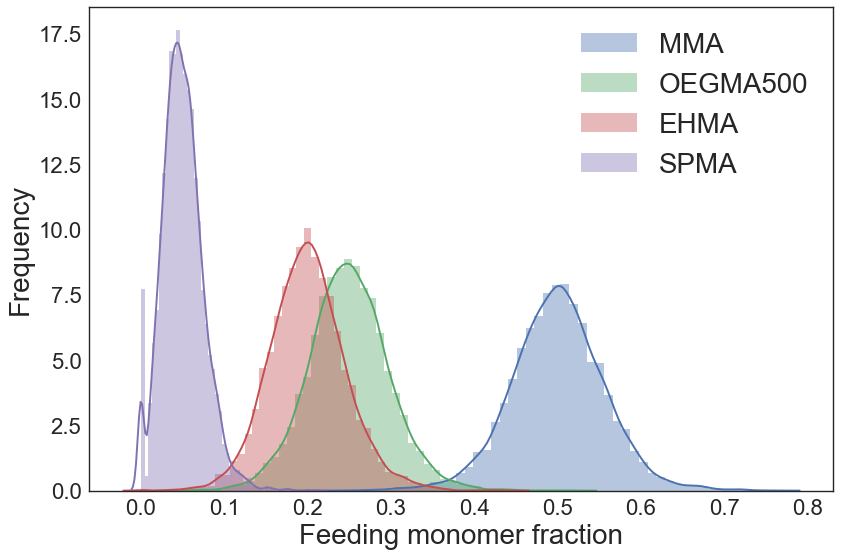

NM4_MR[50, 25, 20, 5]_NC10000_DP125_conv50_CTP10_FILT10
[0.11446032 0.10017072 0.09142513 0.04987112]
[0.22902335 0.40035123 0.4574434  0.99431933]


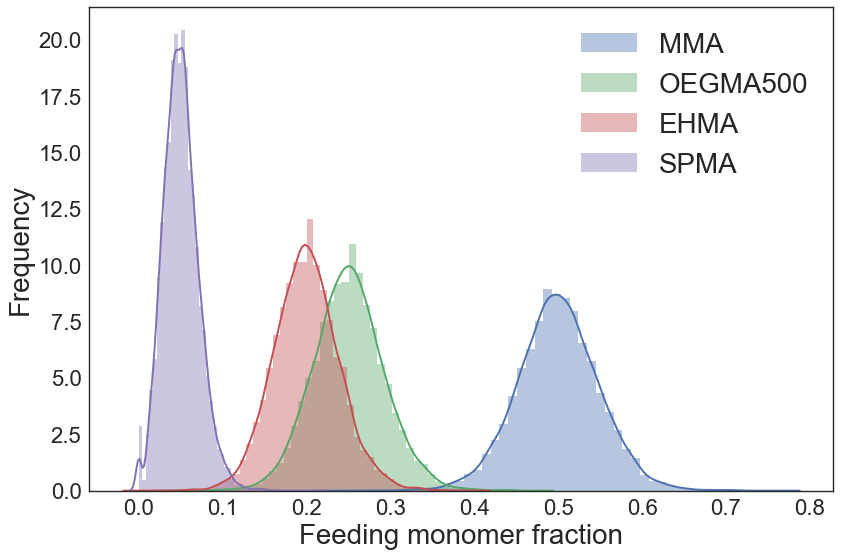

NM4_MR[50, 25, 20, 5]_NC10000_DP150_conv50_CTP10_FILT10
[0.10361538 0.08844318 0.08339716 0.04482885]
[0.2071113  0.35340235 0.41782243 0.89927388]


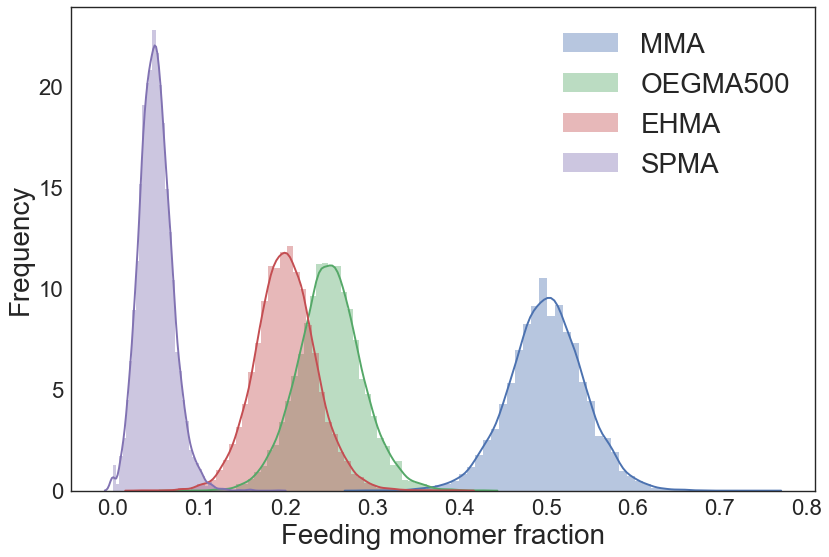

NM4_MR[50, 25, 20, 5]_NC10000_DP175_conv50_CTP10_FILT10
[0.09437745 0.08206803 0.07659204 0.04161897]
[0.18883977 0.32830691 0.38259462 0.83138014]


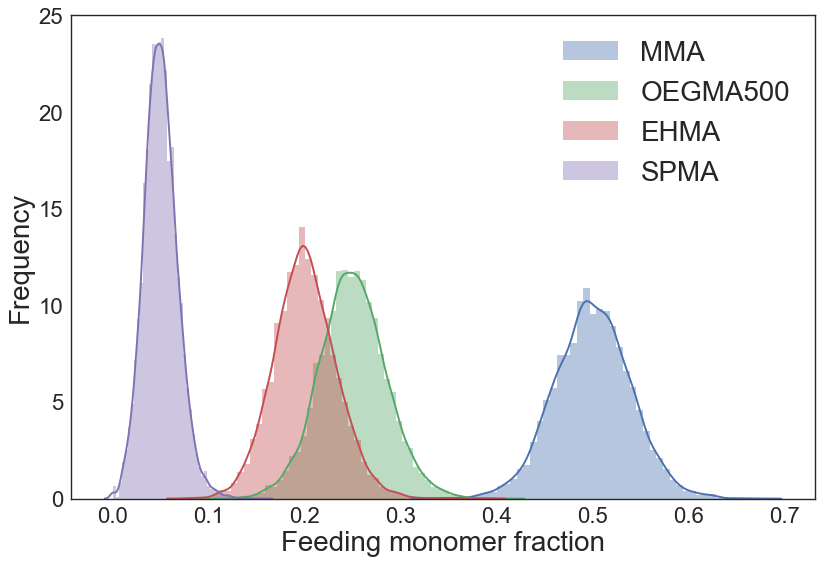

NM4_MR[50, 25, 20, 5]_NC10000_DP200_conv50_CTP10_FILT10
[0.08804598 0.07481237 0.06995827 0.03818217]
[0.17603642 0.29919136 0.35051408 0.76050906]


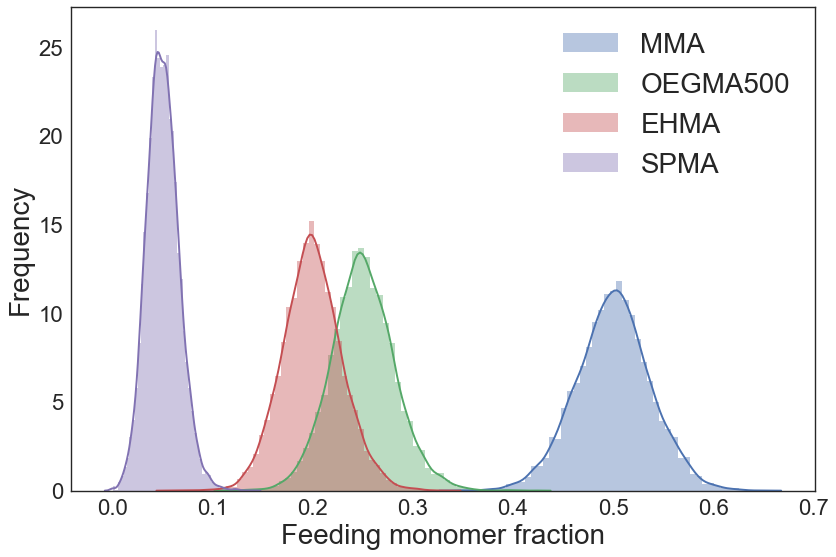

NM4_MR[50, 25, 20, 5]_NC10000_DP225_conv50_CTP10_FILT10
[0.08185288 0.07073567 0.06501305 0.0364874 ]
[0.16378518 0.28273334 0.32490874 0.73031808]


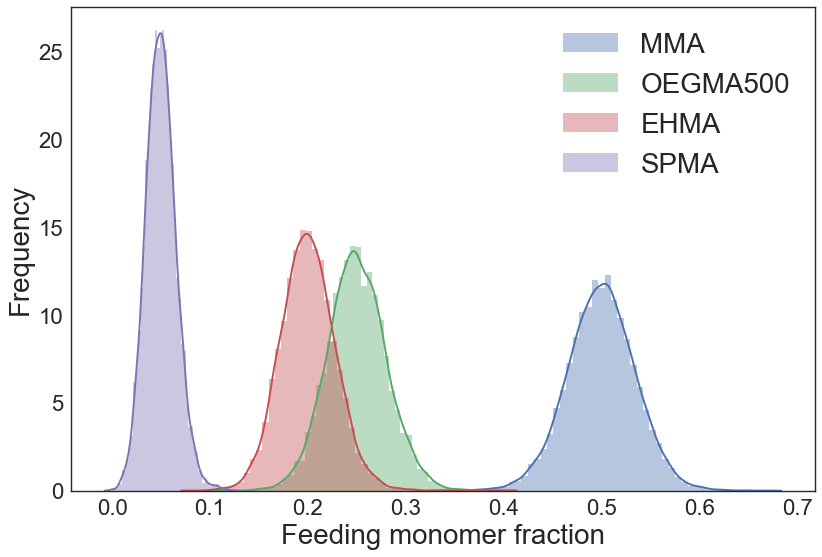

NM4_MR[50, 25, 20, 5]_NC10000_DP250_conv50_CTP10_FILT10
[0.07886942 0.06832904 0.06202487 0.03365015]
[0.15786049 0.27334547 0.30952303 0.67268556]


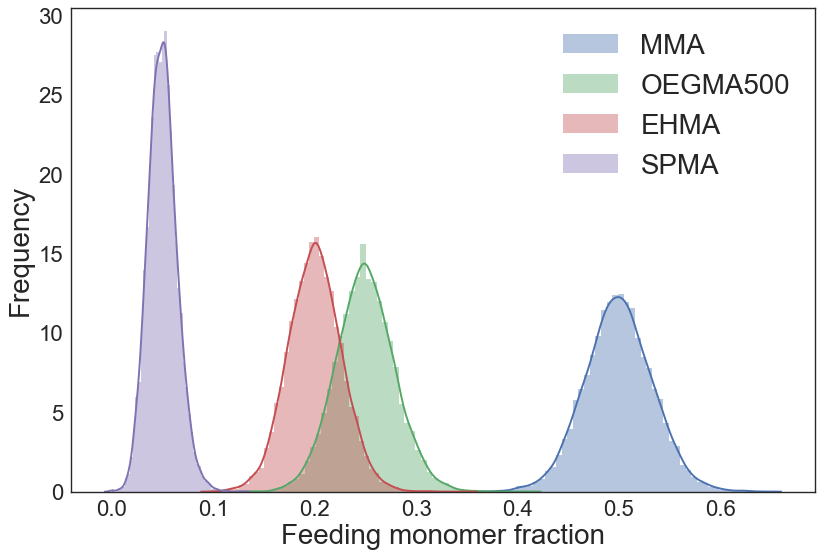

NM4_MR[50, 25, 20, 5]_NC10000_DP50_conv50_CTP10_FILT10
[0.19161488 0.16574525 0.152646   0.084604  ]
[0.38215137 0.66537848 0.76524648 1.69151001]


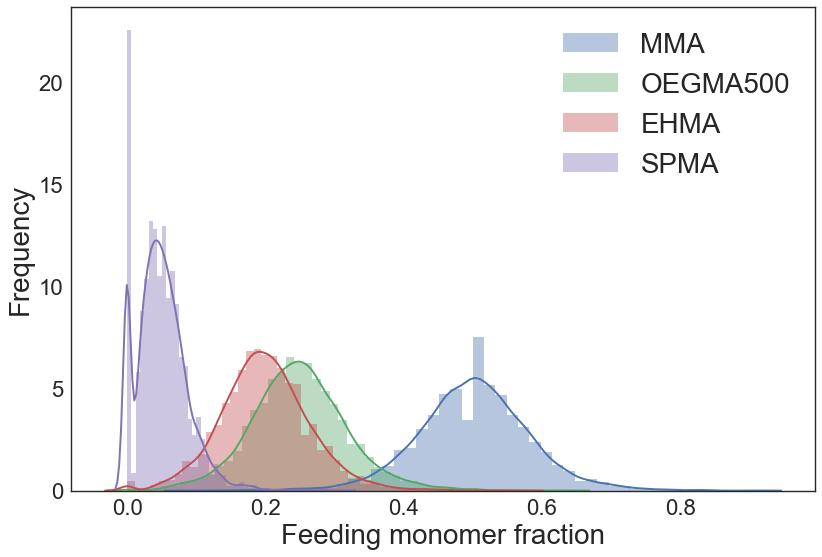

NM4_MR[50, 25, 20, 5]_NC10000_DP75_conv50_CTP10_FILT10
[0.15662075 0.13627774 0.1250623  0.06868947]
[0.3126329  0.54540266 0.62777103 1.37533204]


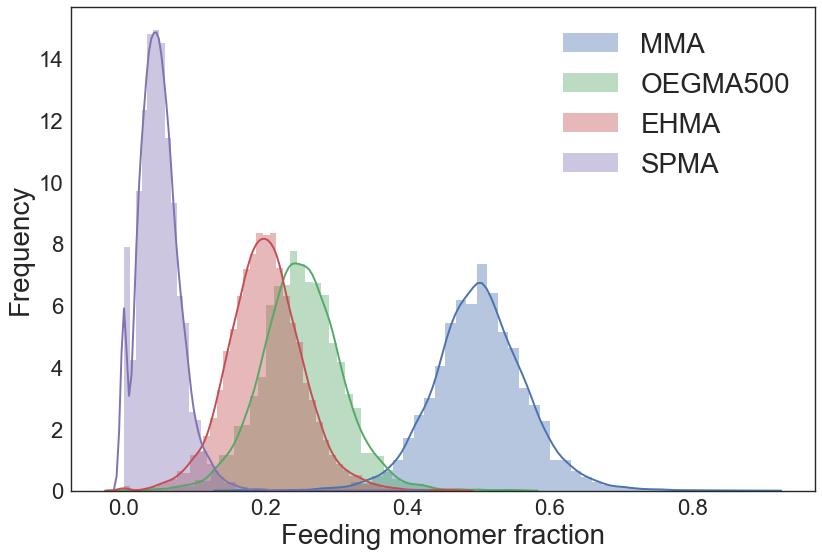

In [7]:
### Histograms of composition on each individual monomer chain:

N_MONS = 4 # number of unique monomers
RUN_ONLY_SUBSET = False # set False if you want to run all sequences

FWHMs = []
FWHM_norms = []

for m in range(len(csv_files)):
    seq = []
    
    if RUN_ONLY_SUBSET:
        if m not in subset_inds:
            continue
    
    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)
            #print(lines)

    seqlen = np.zeros(i)
    seq_comp = np.zeros([i,4])

    for j in range(0,i):
        seqlen[j] = len(seq[j])
        for k in range(4):
            seq_comp[j][k] = seq[j].count(str(k+1))/seqlen[j]
            
    print(csv_files[m].replace(path, '').replace('/', '').replace('.csv', ''))
    FWHM = np.zeros(N_MONS)
    FWHM_norm = np.zeros(N_MONS)
    for i in range(N_MONS):
        #MMA_x, MMA_y = sns.distplot(seq_comp[:,0], label="MMA").get_lines()[0].get_data()
        FWHM[i] = 2.355*np.std(seq_comp[:,i])
        FWHM_norm[i] = 2.355*np.std(seq_comp[:,i])/np.mean(seq_comp[:,i])
    print(FWHM)
    print(FWHM_norm)
    FWHMs.append(FWHM)
    FWHM_norms.append(FWHM_norm)

    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    sns.set_style(style='white') #style='white' or 'darkgrid'
    plt.xlabel("Feeding monomer fraction")
    plt.ylabel("Frequency")
    sns.distplot(seq_comp[:,0], label="MMA")
    sns.distplot(seq_comp[:,1], label="OEGMA500")
    sns.distplot(seq_comp[:,2], label="EHMA")
    sns.distplot(seq_comp[:,3], label="SPMA")
    plt.legend()
    plt.show()

    plt.cla()   # Clear axis
    plt.clf()   # Clear figure

    """ # (same plot but using plt instead of sns)
    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.xlabel("chain composition fraction", fontsize=15)
    #plt.ylabel("asdf")
    plt.hist(seq_comp[:,0], label="MMA")
    plt.hist(seq_comp[:,1], label="OEGMA500")
    plt.hist(seq_comp[:,2], label="EHMA")
    plt.hist(seq_comp[:,3], label="SPMA")
    plt.legend(fontsize=15)
    plt.show()
    """

FWHMs = np.array(FWHMs)
FWHM_norms = np.array(FWHM_norms);

### Plot batch2batch variation (FWHM)
Add 2D array obtained in previous cell to sub-set dataframe (sub_df), the plot a scatter with line of best fit!

In [11]:
for i in range(N_MONs):
    df['FWHM_' + str(i)] = FWHM_norms[:,i]
df

,Batch Name,NumSeqs,Avg Mn,Avg Mw,PDI,Avg DP,FWHM_0,FWHM_1,FWHM_2,FWHM_3
0,"NM4_MR[50, 25, 20, 5]_NC10000_DP100_conv50_CTP...",9986,22710.881083,27114.206606,1.193886,100.129682,0.264399,0.456691,0.534915,1.170526
1,"NM4_MR[50, 25, 20, 5]_NC10000_DP125_conv50_CTP...",9997,28397.590382,32695.895888,1.151362,125.034710,0.229023,0.400351,0.457443,0.994319
2,"NM4_MR[50, 25, 20, 5]_NC10000_DP150_conv50_CTP...",10000,34050.023834,38452.926375,1.129307,150.000000,0.207111,0.353402,0.417822,0.899274
3,"NM4_MR[50, 25, 20, 5]_NC10000_DP175_conv50_CTP...",10000,39728.168068,44115.235378,1.110427,175.000000,0.188840,0.328307,0.382595,0.831380
4,"NM4_MR[50, 25, 20, 5]_NC10000_DP200_conv50_CTP...",10000,45399.579084,49816.149295,1.097282,200.000000,0.176036,0.299191,0.350514,0.760509
5,"NM4_MR[50, 25, 20, 5]_NC10000_DP225_conv50_CTP...",10000,51105.317569,55557.924499,1.087126,225.000000,0.163785,0.282733,0.324909,0.730318
6,"NM4_MR[50, 25, 20, 5]_NC10000_DP250_conv50_CTP...",10000,56764.969608,61145.485871,1.077169,250.000000,0.157860,0.273345,0.309523,0.672686
7,"NM4_MR[50, 25, 20, 5]_NC10000_DP50_conv50_CTP1...",9447,11920.675948,15732.068668,1.319730,52.577750,0.382151,0.665378,0.765246,1.691510
8,"NM4_MR[50, 25, 20, 5]_NC10000_DP75_conv50_CTP1...",9893,17189.525989,21539.916021,1.253084,75.738906,0.312633,0.545403,0.627771,1.375332


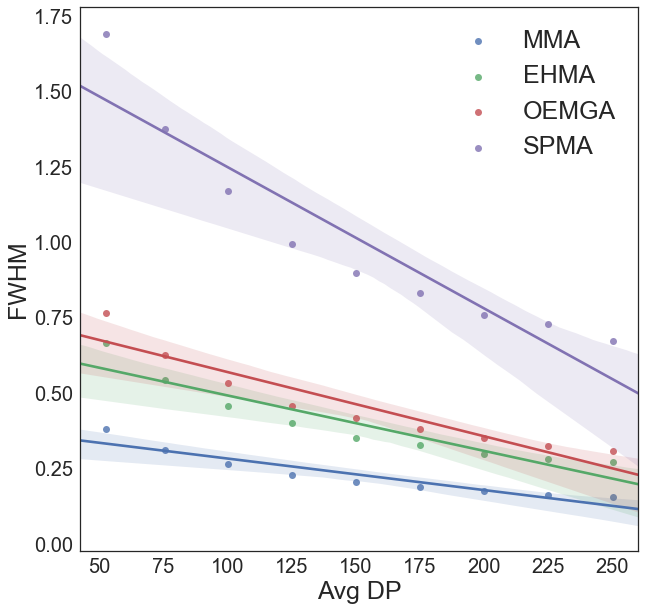

In [12]:
# IF N_MONS changes modify the labels / comment out or add more the ax = ...
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.set_style(style='white') #style='white' or 'darkgrid'
ax = sns.regplot(x="Avg DP", y="FWHM_0", data=df, label='MMA')
ax = sns.regplot(x="Avg DP", y="FWHM_1", data=df, label='EHMA')
ax = sns.regplot(x="Avg DP", y="FWHM_2", data=df, label='OEMGA') 
ax = sns.regplot(x="Avg DP", y="FWHM_3", data=df, label='SPMA')
ax.set_ylabel('FWHM')
#ax.set(ylim=(0, 1))
plt.legend(loc='best')
plt.show()